In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Hawks: a machine learning example

![]() 

## About the data
The data was collected and made available by Professor Bob Black at Cornell College. The dataset provides a great dataset for data exploration, visualisation and - in this case - a demonstration of the scikit-learn API. 

|Field|Description|
|:---|:---|
|bandnumber|The ID band code|
|species|The species of the hawk: Red-tailed, Sharp-shinned or Coopers|
|sex|The gender of the hawk - Female (F) or Male (M)|
|wing|	Length (in mm) of primary wing feather from tip to wrist it attaches to|
|weight|Body weight (in gm)|
|culmen|Length (in mm) of the upper bill|
|hallux|	Length (in mm) of the killing talon|
|tail|Measurement (in mm) related to the length of the tail (invented at the MacBride Raptor Center)|
|maturity| Maturity of the hawk - Adult or Infant|

## Scikit-Learn
Scikit-learn is *the* library for machine learning in Python. You could consider it the swiss army knife of machine learning. A wide variety of machine learning models are implemented by the community and core developers, with a consistent API. Once you master this API, it's easy to apply a wide variety of machine learning algorithms, and you have a handy tool to help you out with preprocessing, model evaluation and model selection. 

#### Why scikit-learn?
- Many available machine learning models
- Models are implemented by an expert team and checked by a large community
- Covers most machine-learning tasks
- Commitment to documentation, consistency and usability
- Designed to work with other key Python libraries (NumPy, Pandas etc)


## Hawk classification
In this notebook, we will demonstrate classification of hawks species based on bodily measurements with the scikit-learn API. We will cover the following aspects:

1. Loading the data
2. Preparing the data for sklearn
3. Model creation & evaluation
4. Data pre-processing
5. Pipelines

## 1. Loading our data

There are many places your data can originate from. Maybe you want to load it from a Excel file you have stored locally on your system, maybe you have a .csv file stored online somewhere. Scikit-learn comes with various standard datasets that can be used for practice, that can be loaded if you have scikit-learn installed on your system. 

However, the dataset we will be using today (the R hawks dataset) does not come from scikit-learn, but from a package in R. Luckily for us we can access that data [from here](https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Hawks.csv)

The data has been downloaded stored here: `'data/hawks.csv'`.

In [2]:
hawks = pd.read_csv('../data/hawks.csv')
hawks.head()

,bandnumber,species,sex,wing,weight,hallux,tail,maturity
0,1142-09240,Sharp-shinned,M,166.0,120.0,11.7,133,NaN
1,1142-09241,Sharp-shinned,M,170.0,110.0,121.0,135,NaN
2,1142-09242,Sharp-shinned,M,165.0,95.0,11.6,131,Infant
3,1142-18229,Sharp-shinned,M,161.0,95.0,11.3,135,Infant
4,1142-19209,Sharp-shinned,M,165.0,96.0,11.4,125,NaN


## 2. Preparing the data for scikit-learn

The first thing we might notice here is that there are some data point entries that have no value - the value simply says `NaN`. This means this information is missing. 

Unfortunately, that also means the information cannot be used as is to create a machine learning model with scikit-learn. We must find a way to deal with the missing values. 

There are multiple strategies for dealing with missing data. For example, you could replace a missing values with the mean of the column. E.g. if for a particular hawk the value for body mass is missing, you could replace the NaN with the mean recorded body mass of all hawk. 

Scikit-learn even provides us with a great interface to apply such transformations. For the moment, however, we simply choose to discard all the incomplete data points with pandas `.dropna()` functionality. 

In [3]:
# Drop the rows with missing values
hawks.dropna()

,bandnumber,species,sex,wing,weight,hallux,tail,maturity
2,1142-09242,Sharp-shinned,M,165.0,95.0,11.6,131,Infant
3,1142-18229,Sharp-shinned,M,161.0,95.0,11.3,135,Infant
5,1142-19210,Sharp-shinned,M,163.0,100.0,11.6,128,Infant
6,1142-19211,Sharp-shinned,M,163.0,100.0,11.3,131,Infant
7,1142-19212,Sharp-shinned,F,165.0,95.0,11.2,136,Infant
...,...,...,...,...,...,...,...,...
898,877-76552,Red-tailed,M,380.0,760.0,26.1,212,Infant
900,8777-6382,Red-tailed,F,363.0,1015.0,30.1,242,Infant
901,9387-92182,Red-tailed,F,382.0,1080.0,31.0,214,Infant
902,972-04635,Sharp-shinned,M,165.0,98.0,11.4,138,Infant


Second of all, we notice that we have more information than just the numeric measurements of the hawks. 

We may incorporate this information later which will require some extra preprocessing. For now we choose to focus on our four discussed features first.

In [4]:
# Drop the unwanted columns
hawks_prep = (
    hawks
    .dropna()
    [['species','wing','weight','hallux','tail']]
)

For machine learning algorithms in Sklearn we must split our data into our feature matrix *X* and target vector *y*.

In [5]:
# Split the data in a matrix X and target vection y

feature_columns = ['wing','weight','hallux','tail']

X = hawks_prep[feature_columns]
y = hawks_prep['species']

In [6]:
# Look at the first five rows of both X and y
X.head()

,wing,weight,hallux,tail
2,165.0,95.0,11.6,131
3,161.0,95.0,11.3,135
5,163.0,100.0,11.6,128
6,163.0,100.0,11.3,131
7,165.0,95.0,11.2,136


In [7]:
y.head()

2    Sharp-shinned
3    Sharp-shinned
5    Sharp-shinned
6    Sharp-shinned
7    Sharp-shinned
Name: species, dtype: object

In [8]:
# Check the unique values of y
y.unique()

array(['Sharp-shinned', 'Red-tailed', 'Coopers'], dtype=object)

### Splitting the dataset
An important goal of machine learning is to create a model that does not only do well on the data that it has already seen, but will also perform well under new circumstances on data that is has not seen before. We call this _generalization_. 

Imagine this: Hawk A is a coopers hawk. Hawk A was presented during the training of our model; that means, Hawk A was one of the examples that the algorithm used to create an understanding of what a coopers hawk looks like and how you can distinguish it from a red-tailed or sharp-shinned. 

If we want to know how well our model does, asking the model to classify our Hawk A does not give us a lot of information. Even if the model is correct, do we know whether it has really truly learned the relationship between the features and the targets (ie. flipper length of >X is always species Y), or has it simply memorized the original data and does it recognise Hawk A from the training phase? 

That's why we want to separate our dataset into two parts:
* The _training_ set: this is the data (features and targets) that will guide the learning process. 
* The _test_ set: this is the data (features and targets) that we will use to _evaluate_ how well our model has learned. 

Scikit-learn's `train_test_split` function allows us to split the data in a train- and testset. By default, the test set size is set to 25% and the data is shuffled. 

In [9]:
# Import and use the train_test_split function to 
# split the data into train and test datasets
# The train dataset should be 30% of the original data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
# Check the shape of the train/test datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(504, 4) (168, 4) (504,) (168,)


## 3. Model creation and evaluation

Now we're ready to create our machine learning model! 

Scikit-learn has a rich collection of algorithms readily available. Depending on the case you are working on, scikit-learn most likely has a model that will suit your purposes. 

#### Scikit-Learn API usage steps when training a model
1. Choosing a model class and importing that model 
2. Choosing the model hyperparameters by instantiating this class with desired values.
3. Training the model to the preprocessed train data by calling the `fit()` method of the model instance.
4. Evaluating model's performance using available metrics

In [11]:
# Step 1: import the chosen algorithm - DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
# Step 2: instantiate the model with the chosen hyperparameters
model = DecisionTreeClassifier()

In [13]:
# Step 3: train the model with the training data
model.fit(X_train, y_train)

DecisionTreeClassifier()

We have now trained a model that can be used to make predictions on new data. Remember our test set? That's new, unseen data to the model that we can now create predictions on. 

In [14]:
# Create predictions for the y test set using the .predict() method
y_pred = model.predict(X_test)

Fortunately, we don't have to comparisons ourselves. Scikit-learn has made many implementations of possible metrics readily available, such as accuracy. 

$\text{accuracy} = \frac{correct}{total}$

In [15]:
# import and find the accuracy_score for your model
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9821428571428571

Accuracy is not the only metric you could be interested in. Alternatives are, for example, _precision_ and _recall_. 

* _Precision_ is the proportion of positive identifications that was actually correct. 
* _Recall_ is the proportion of actual positives that was identified correctly.
* _F1 score_ is a function of precision and recall, that you use when you seek a balance between precision and recall. 

A simple example is this: 
Let's say you create a model that should classify email messages as spam or not spam. _Precision_ measures the percentage of emails flagged as spam that were correctly classified, while _recall_ measures the percentage of actual spam emails that were correctly classified. 

In some cases, precision is more important. For YouTube's recommendation system for example: you won't be able to show _ALL_ relevant videos, but it is important that the ones you do show _are_ relevant. 

However, in medical context, _recall_ is often more important. After all, if we mistakingly tell a person with cancer that they're healthy, that can have more severe consequences than the other way around. 

Precision, recall and F1 are also all available with scikit-learn.

In [16]:
# Display the confusion_matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[  5   1   0]
 [  0 118   1]
 [  1   0  42]]


In [17]:
# Check the precision and recall with  classification_report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

      Coopers       0.83      0.83      0.83         6
   Red-tailed       0.99      0.99      0.99       119
Sharp-shinned       0.98      0.98      0.98        43

     accuracy                           0.98       168
    macro avg       0.93      0.93      0.93       168
 weighted avg       0.98      0.98      0.98       168



## Model Visualisation

One of the advantages of decision trees over some of the other available models, is that decision trees are relatively easy to interpret. By visualising the tree-like structure of the decision tree, we can understand why the model classifies samples the way it does.

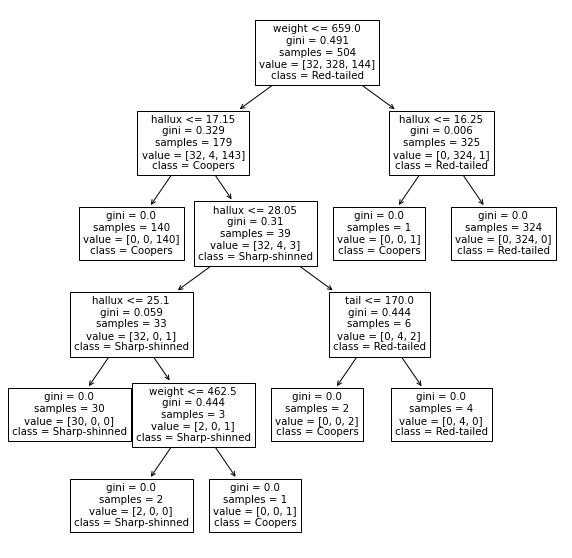

In [18]:
# Use plot_tree to visualise your model
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(10,10))

plot_tree(model, 
          ax=ax, 
          feature_names = feature_columns, 
          class_names = y.unique());

## Exercise: Choosing a different model 

What happens when we're interested in a model other than the decision tree? 

That's actually really easy. You simply replace the chosen model with another and the rest of the pipeline can stay the same.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Create, train and evaluate your own model for the `hawks` dataset. 

1. **Choose your model.** Try something other than a decision tree. Perhaps a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) or [K-nearest neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) classifier?
2. **Instantiate your model.** Set some hyperparameters! Look at the documentation to see what parameters you can set.  
3. **Fit your model** on the train features and labels.
4. **Make predictions** on the test features.  
5. **Evaluate your model.** Choose your own metric. Perhaps one of the [other metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) implemented in Scikit-Learn? 

In [20]:
# model = DecisionTreeClassifier()
model = RandomForestClassifier()
# model = SVC()
# model = KNeighborsClassifier()

In [21]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f'Model accuracy: {model.score(X_test, y_test)}')
print(report)

Model accuracy: 0.9880952380952381
               precision    recall  f1-score   support

      Coopers       1.00      0.83      0.91         6
   Red-tailed       0.99      0.99      0.99       119
Sharp-shinned       0.98      1.00      0.99        43

     accuracy                           0.99       168
    macro avg       0.99      0.94      0.96       168
 weighted avg       0.99      0.99      0.99       168



# Summary

Scikit-learn is an excellent, resourceful tool for machine learning in Python. We've seen how we can split a dataset with `train_test_split` into a train and test set, create and train a model, use the trained model to create predictions, and how to use the tools from `sklearn.metrics` to evaluate how good the model is.